#### Load momemta results

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

momemta_out = np.genfromtxt("weights10.csv", delimiter=",")

benchmarks = momemta_out[0,:-1]
n_benchmarks = benchmarks.shape[0]
momemta_weights = momemta_out[1:,:-1]
n_events = momemta_weights.shape[0]
expected_benchmark_idx = 12
top_width = 1.5
print 'expected benchmark: {}'.format(benchmarks[expected_benchmark_idx])
print benchmarks

expected benchmark: 172.0
[160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173.
 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185.]


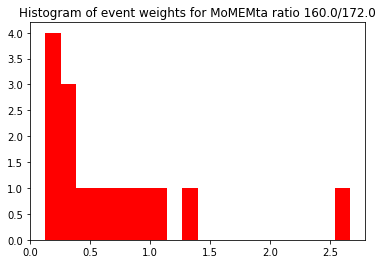

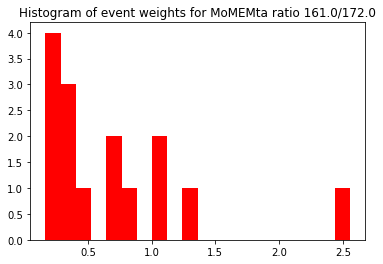

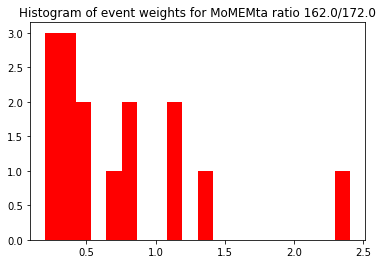

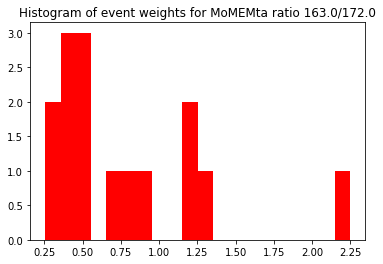

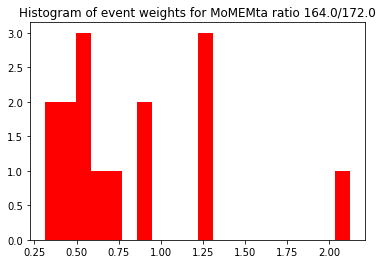

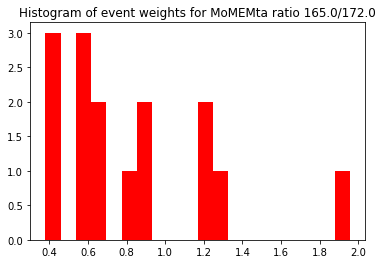

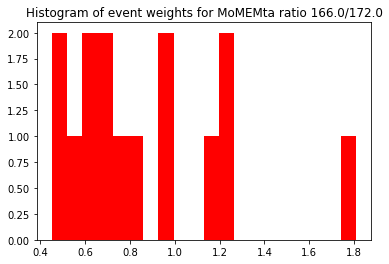

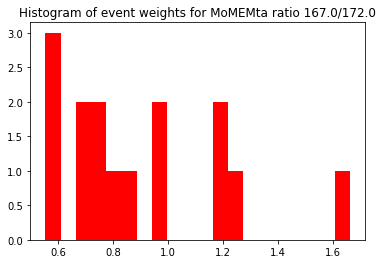

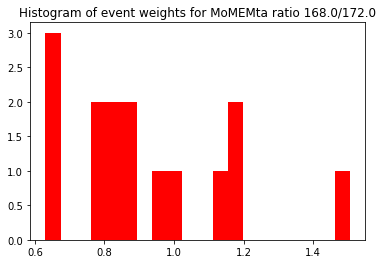

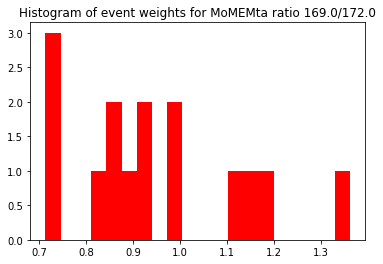

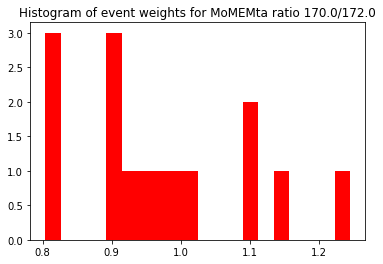

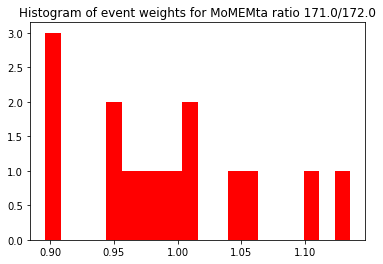

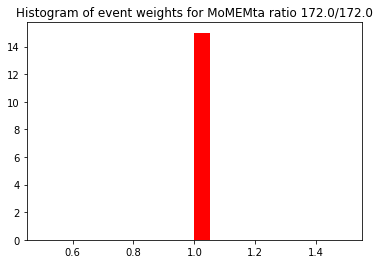

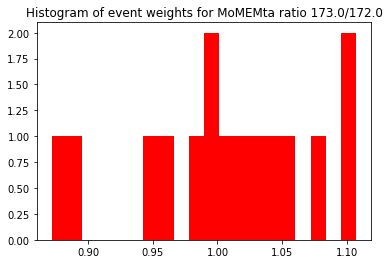

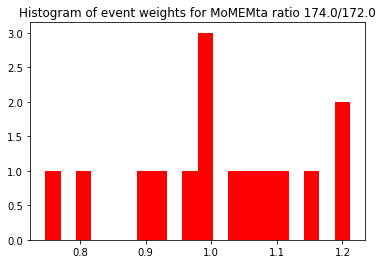

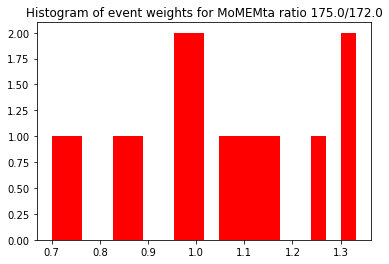

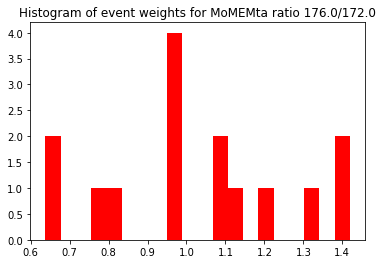

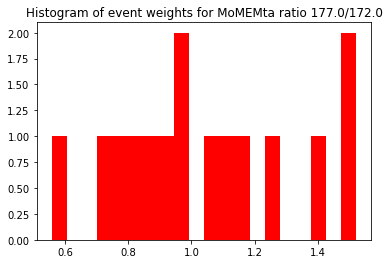

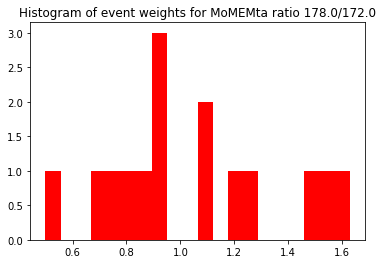

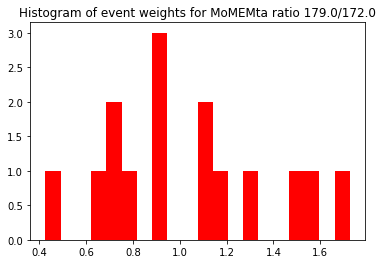

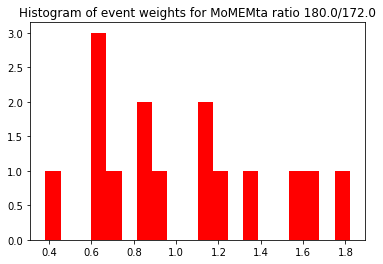

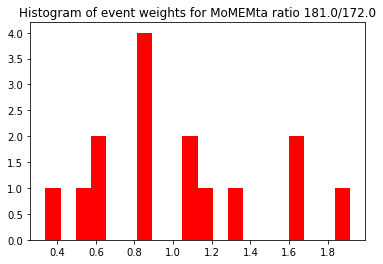

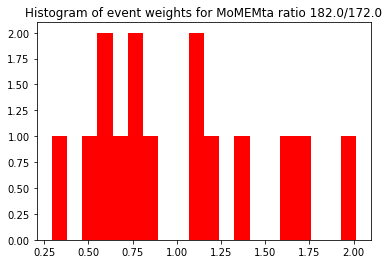

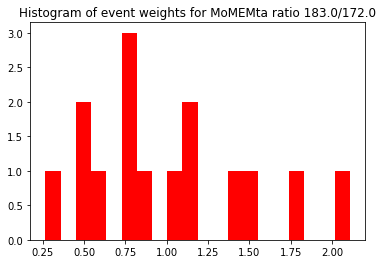

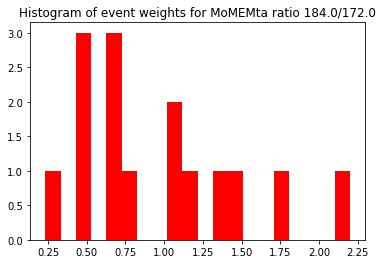

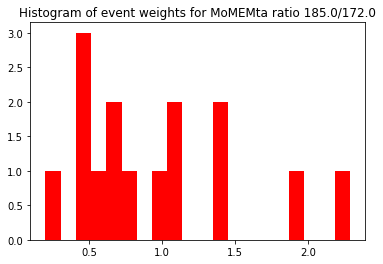

In [2]:
momemta_ratios = []
for event_weights in momemta_weights:
    momemta_ratios.append(event_weights/event_weights[expected_benchmark_idx])
momemta_ratios = np.array(momemta_ratios)

for idx, benchmark in enumerate(benchmarks):
    plt.hist(momemta_ratios[:,idx],bins=20, color='red')
    plt.title('Histogram of event weights for MoMEMta ratio {}/{}'.format(benchmarks[idx], benchmarks[expected_benchmark_idx]))
    plt.show()

In [3]:
momemta_log_sq_ratios = []
momemta_log_ratios = []
for ratio in momemta_ratios:
    momemta_log_ratios.append(np.log(ratio))
    momemta_log_sq_ratios.append(-2 * np.log(ratio))
    
momemta_log_ratios = np.array(momemta_log_ratios)
momemta_log_sq_ratios = np.array(momemta_log_sq_ratios)

print momemta_log_sq_ratios[0][0], momemta_log_sq_ratios[0][expected_benchmark_idx], momemta_log_sq_ratios[0][-1]

2.71030899647003 -0.0 -0.60219004494049


In [4]:
momemta_sum_log_sq_ratios = np.sum(momemta_log_sq_ratios, axis=0)
print momemta_sum_log_sq_ratios

[23.17757177 19.5048646  16.34549864 13.42521985 10.5254098   8.45649146
  6.42855335  4.76322289  3.30356122  2.06773432  1.0778771   0.31271404
  0.         -0.09474975 -0.06446545 -0.22037856 -0.05311673 -0.14731334
  0.15110551  0.87461813  1.68925208  1.78947794  3.17525755  3.81933848
  5.32071642  6.64261458]


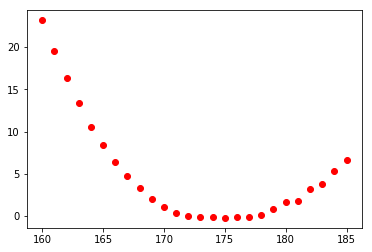

In [5]:
plt.plot(benchmarks, momemta_sum_log_sq_ratios, 'o', color='red');

#### Load madminer model and extract event-level ratios

In [6]:
from madminer.ml import ParameterizedRatioEstimator

In [7]:
forge = ParameterizedRatioEstimator(n_hidden=(100, 100))
forge.load('/home/zbhatti/codebase/madminer/momemta/inputs/alice')
theta0 = np.vstack( (np.linspace(benchmarks[0], benchmarks[-1], n_benchmarks), top_width*np.ones(n_benchmarks)) ).T
x = np.load('/home/zbhatti/codebase/madminer/momemta/inputs/x_test_wo_smearing.npy')[:n_events,:]
log_ratios_T, _0 = forge.evaluate_log_likelihood_ratio(x=x, theta=theta0, test_all_combinations=True, run_on_gpu=False)
n_observables = x.shape[1]
print theta0.shape, x.shape, log_ratios_T.shape

(26, 2) (15, 23) (26, 15)


[ 5.2860208   4.3615255   3.512734    2.7357464   2.0381882   1.4341494
  0.9370351   0.55626273  0.29836833  0.16838352  0.1684706   0.29583102
  0.5432437   0.9022535   1.3662106   1.930838    2.5923371   3.3448744
  4.1792865   5.083253    6.042405    7.041523    8.0656395   9.100872
 10.135012   11.157883  ]


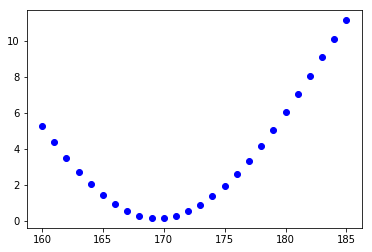

In [8]:
madminer_log_ratios = log_ratios_T.T
madminer_log_sq_ratios = -2*madminer_log_ratios
madminer_sum_log_sq_ratios = np.sum(-2*madminer_log_ratios, axis=0)
print madminer_sum_log_sq_ratios
plt.plot(benchmarks, madminer_sum_log_sq_ratios, 'o', color='blue')


# Comparing madminer with MoMEMta

### compare all events with all bechmarks

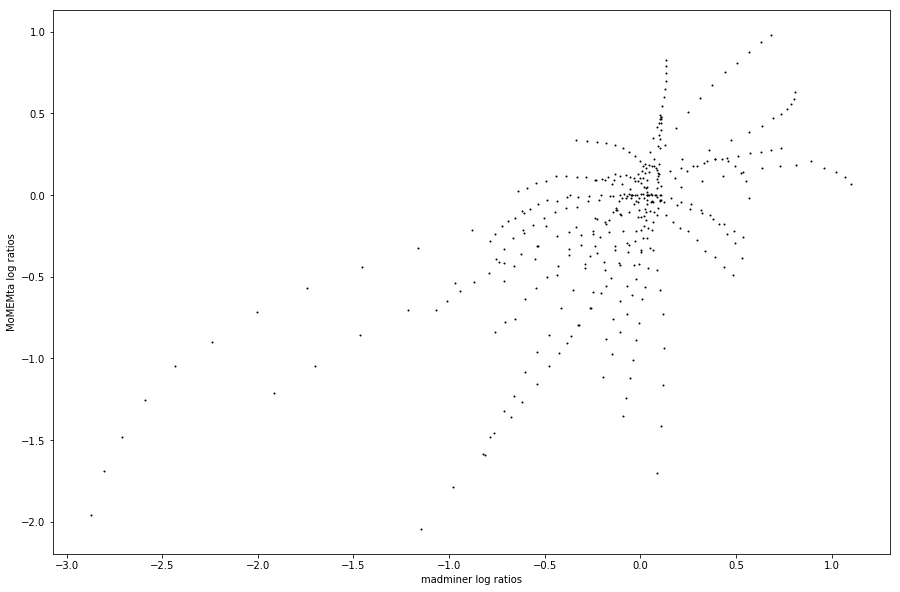

In [9]:
plt.figure(figsize=(15,10))
plt.scatter(madminer_log_ratios, momemta_log_ratios, marker='o', color='black', s=1);
plt.xlabel('madminer log ratios')
plt.ylabel('MoMEMta log ratios')
plt.show()

### compare each event for all benchmarks

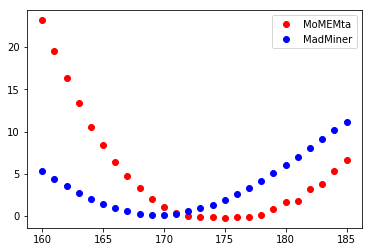

In [18]:
plt.plot(benchmarks, momemta_sum_log_sq_ratios, 'o', color='red', label='MoMEMta');
plt.plot(benchmarks, madminer_sum_log_sq_ratios, 'o', color='blue', label='MadMiner')
plt.legend()
plt.show()

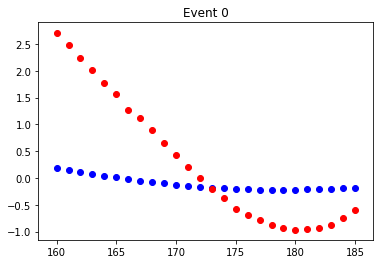

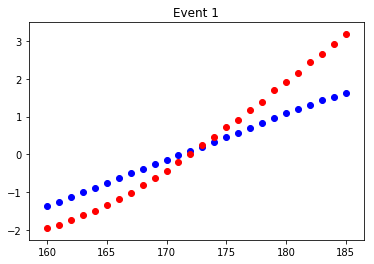

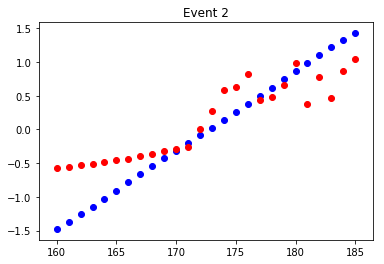

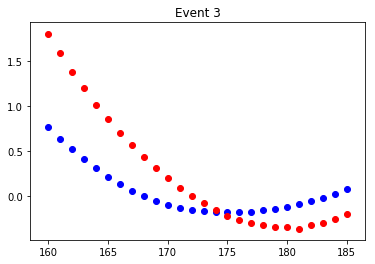

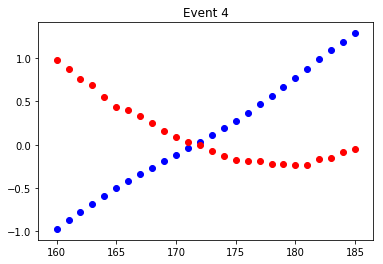

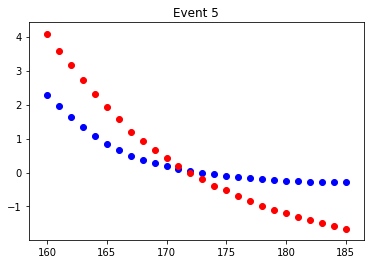

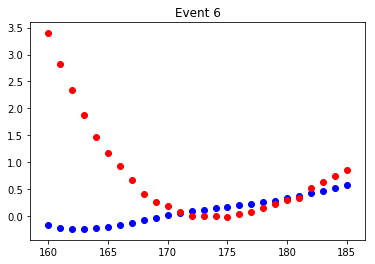

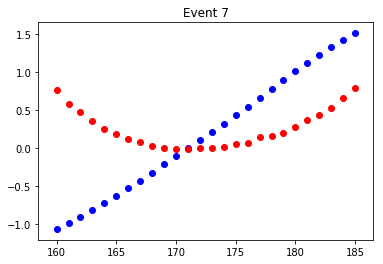

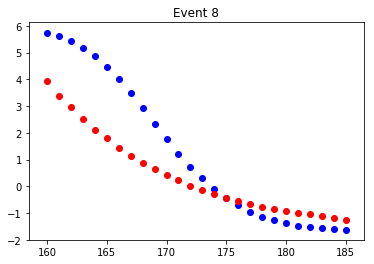

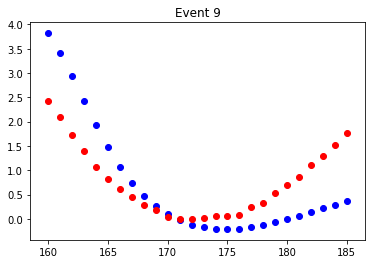

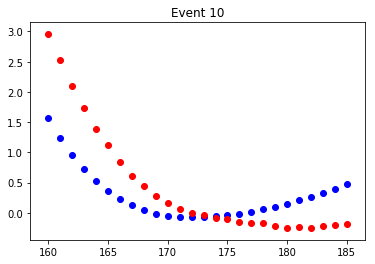

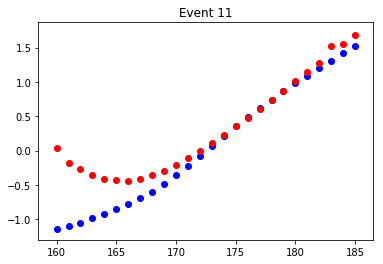

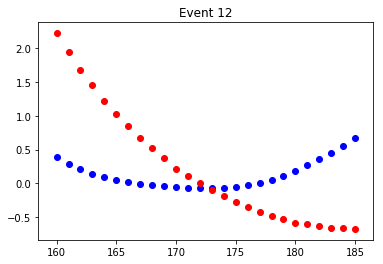

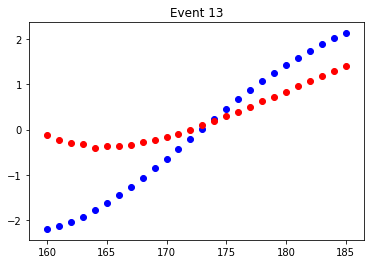

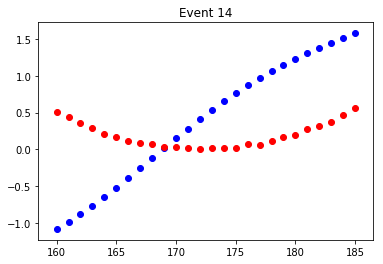

In [14]:
for i in range(0, n_events):
    plt.scatter(benchmarks, madminer_log_sq_ratios[i], marker='o', color='blue')
    plt.scatter(benchmarks, momemta_log_sq_ratios[i] - momemta_log_sq_ratios[i, expected_benchmark_idx], marker='o', color='red')
    plt.title('Event {}'.format(i))
    plt.show()

### compare all events for each bechmark

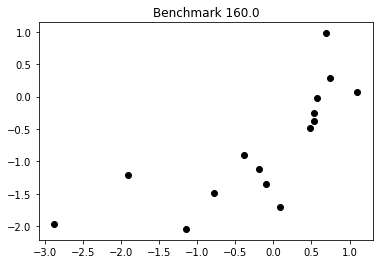

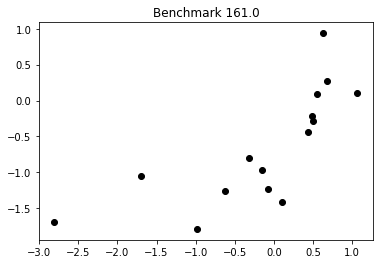

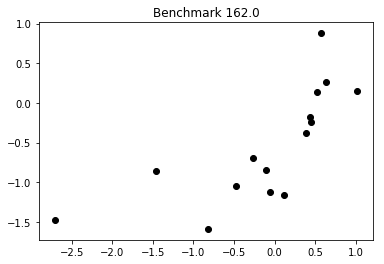

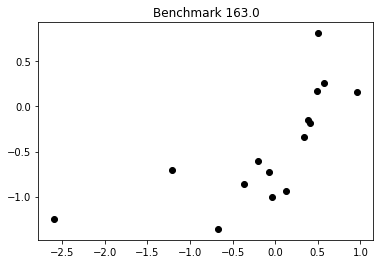

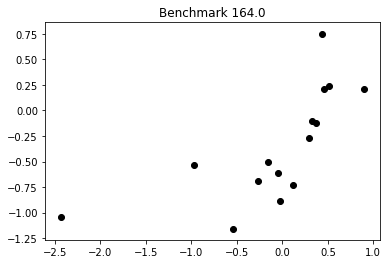

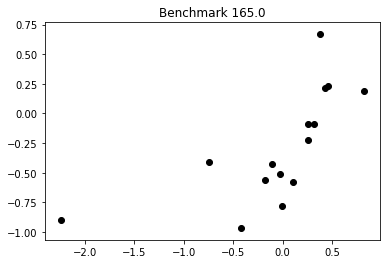

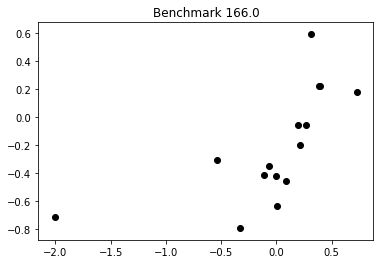

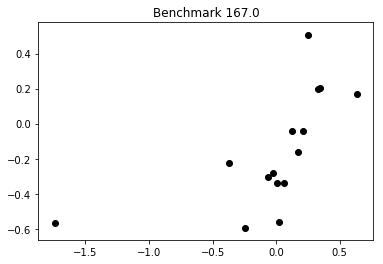

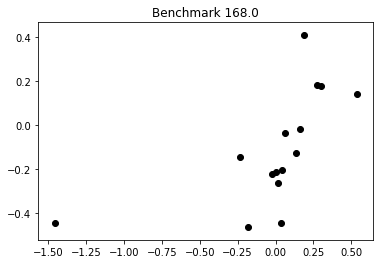

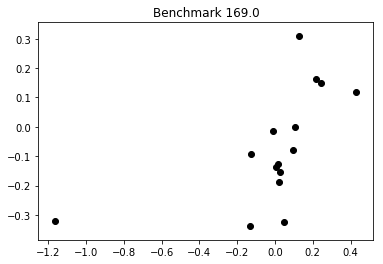

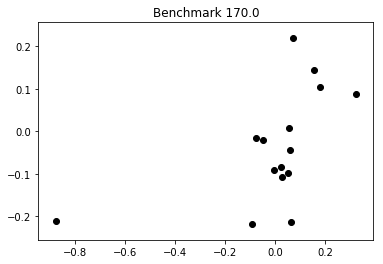

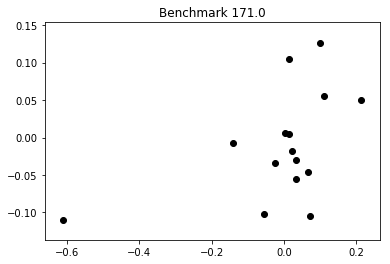

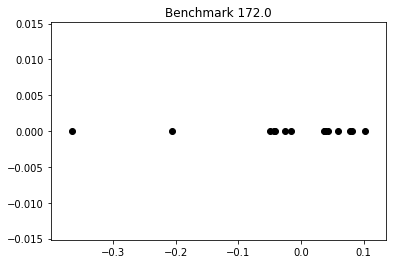

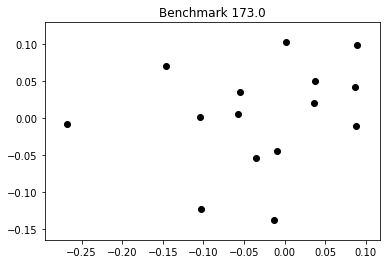

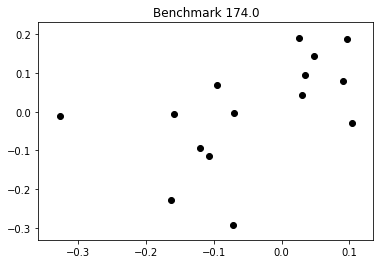

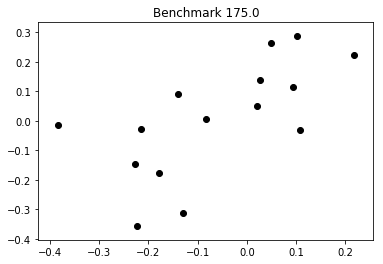

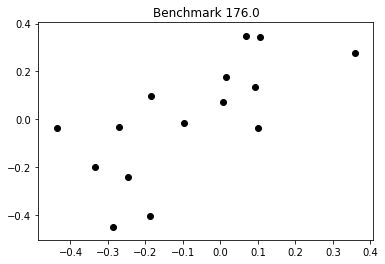

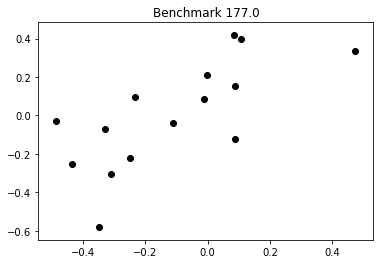

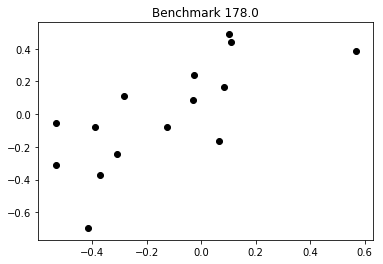

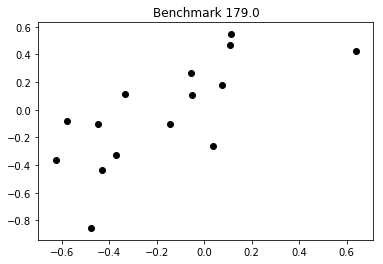

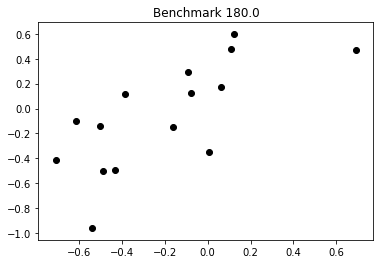

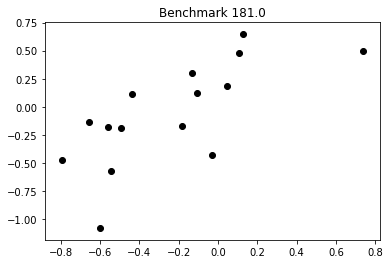

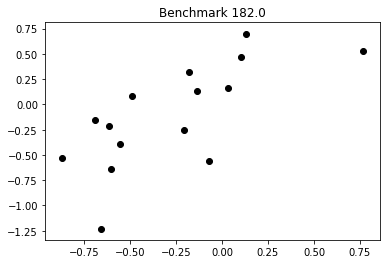

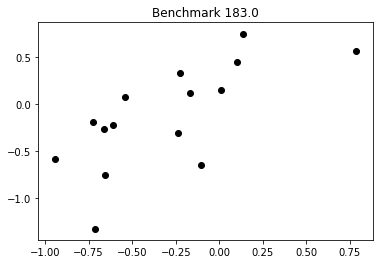

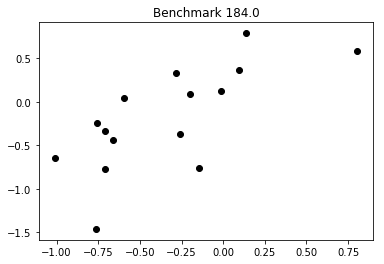

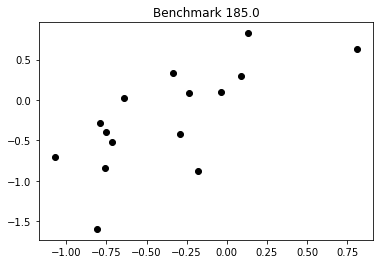

In [15]:
for i in range(0,madminer_log_ratios.shape[1]):
    plt.scatter(madminer_log_ratios[:,i], momemta_log_ratios[:,i] - momemta_log_ratios[:,expected_benchmark_idx], marker='o', color='black');
    plt.title('Benchmark {}'.format(benchmarks[i]))
    plt.show()

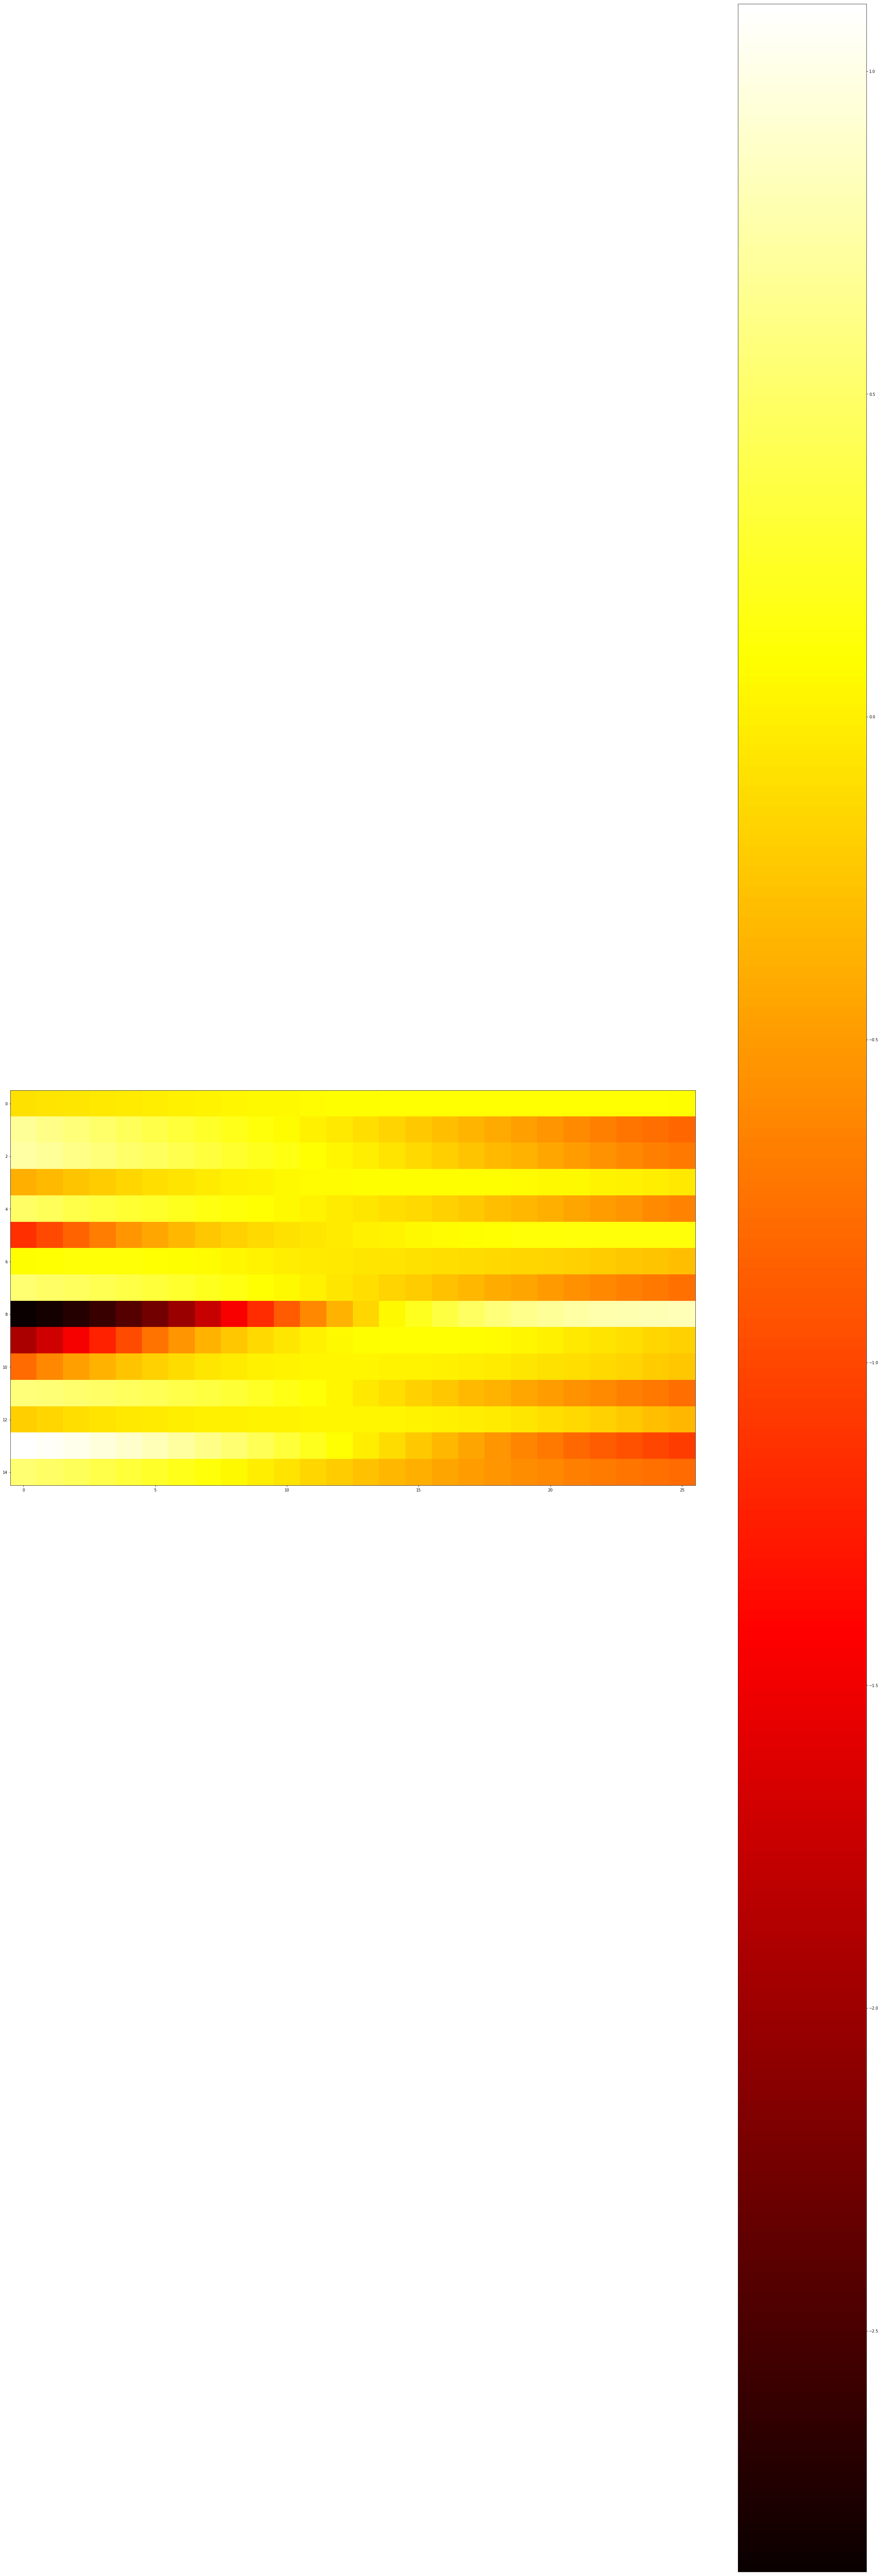

In [16]:
plt.figure(figsize=(40, 170))
plt.imshow(madminer_log_ratios, cmap='hot', interpolation='nearest')
plt.colorbar()


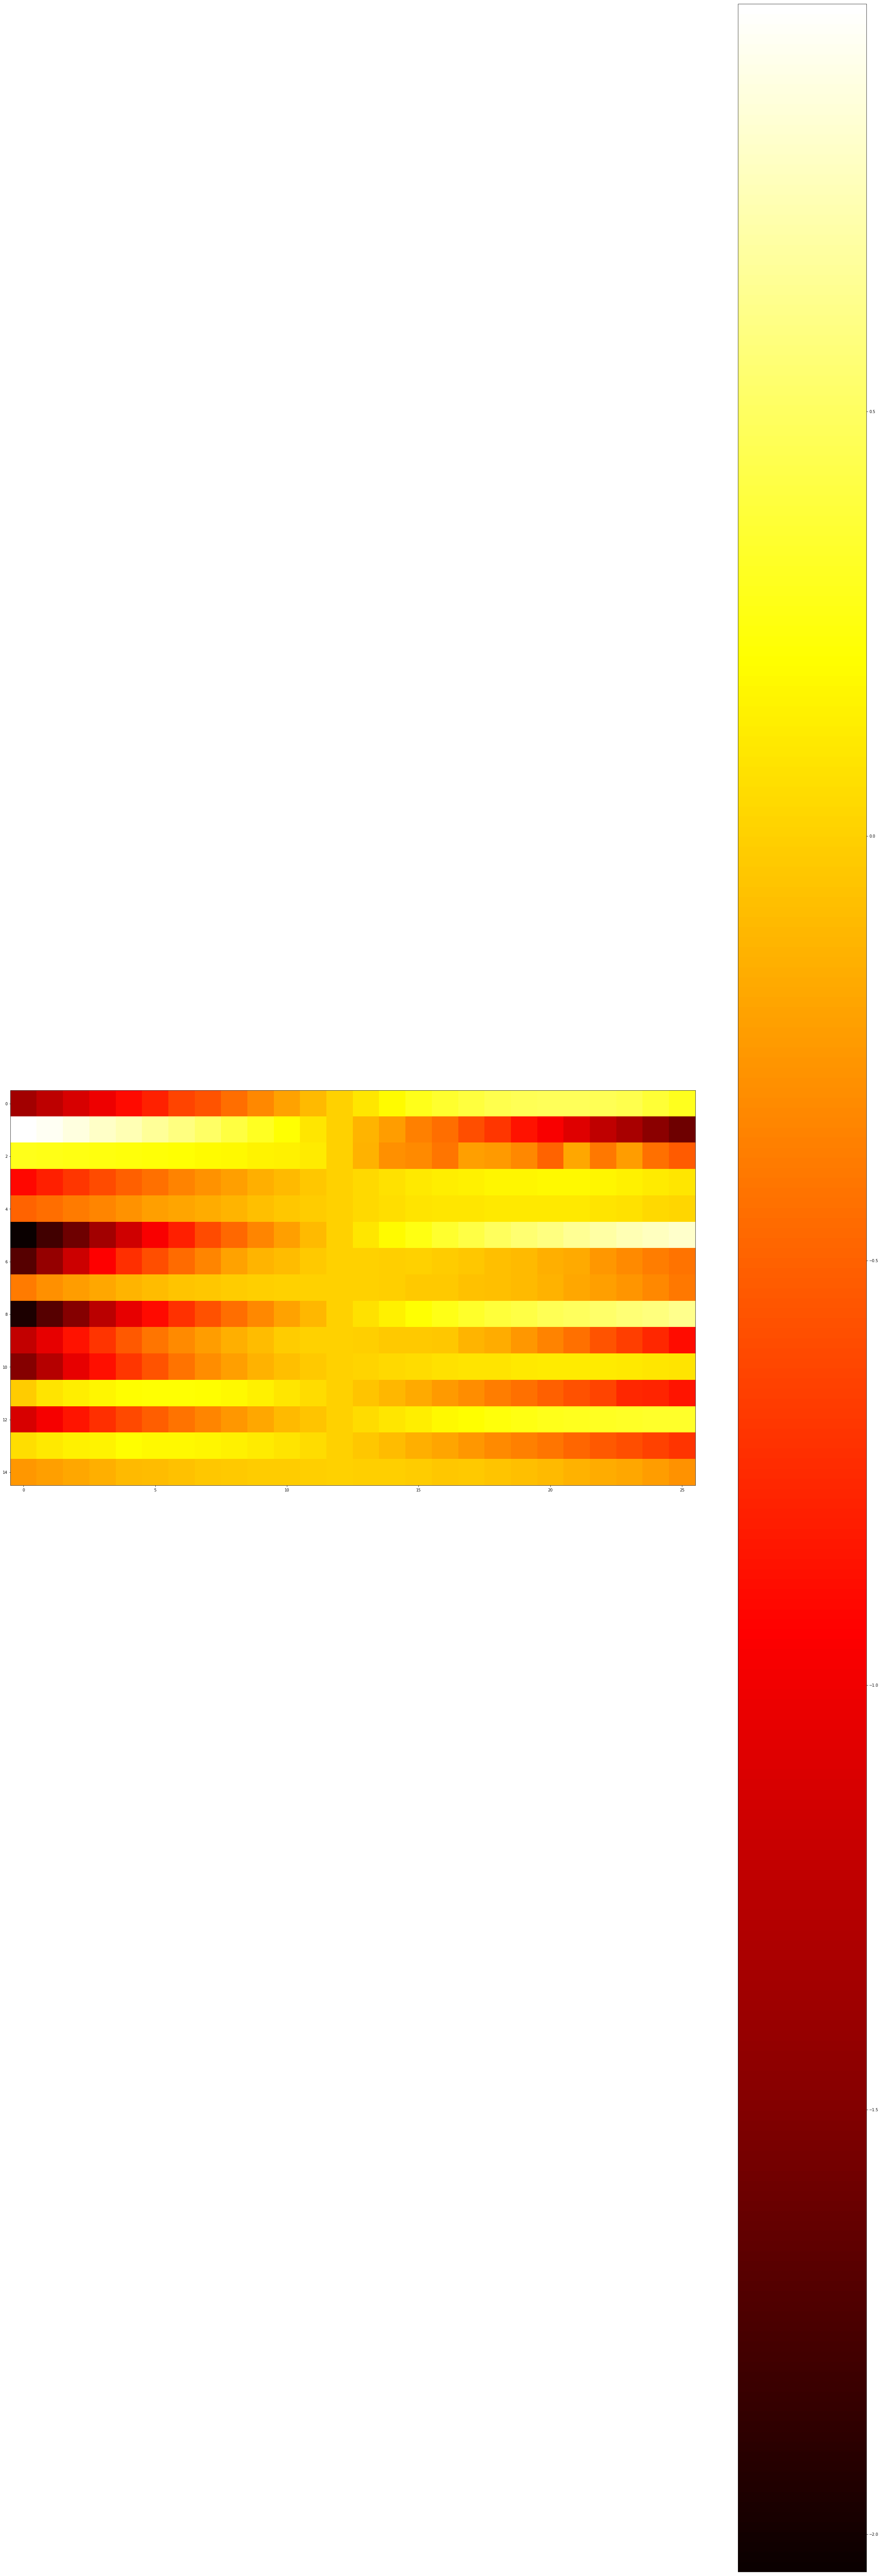

In [17]:
plt.figure(figsize=(40, 170))
plt.imshow(momemta_log_ratios, cmap='hot', interpolation='nearest')
plt.colorbar()